In [1]:
#! wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
#! chmod +x Miniconda3-latest-Linux-x86_64.sh
#! bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local

! wget -c https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.3-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.3-Linux-x86_64.sh -b -f -p /usr/local

! conda install -q -y -c rdkit rdkit

import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
!pip install git+https://github.com/keras-team/keras-tuner.git

--2020-09-14 01:23:26--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88867207 (85M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.3-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  84.75M   236MB/s    in 0.4s    

2020-09-14 01:23:27 (236 MB/s) - ‘Miniconda3-py37_4.8.3-Linux-x86_64.sh’ saved [88867207/88867207]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - ca-certificates==2020.1.1=0
    - certifi==2020.4.5.1=py37_0
    - cffi==1.14.0=py37he30daa8_1
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.1=py37h7b6447c_0
    - conda==4.8.3=py

In [2]:
import warnings , os, re
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf

import tensorflow.keras as keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from keras.utils import np_utils

from kerastuner.tuners import RandomSearch, BayesianOptimization
from kerastuner.engine.hypermodel import HyperModel
from kerastuner.engine.hyperparameters import HyperParameters, Choice

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Draw, rdDistGeom
from rdkit.Chem.Draw import IPythonConsole
from rdkit import RDLogger
RDLogger.logger().setLevel(RDLogger.CRITICAL)

Create molecule

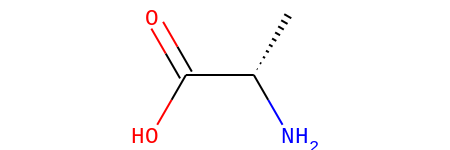

In [3]:
ala = Chem.MolFromSmiles( 'N[C@@H](C)C(O)=O' )
ala

In [4]:
Chem.MolToSmiles(ala)

'C[C@H](N)C(=O)O'

In [5]:
Chem.MolToMolBlock(ala)

'\n     RDKit          2D\n\n  6  5  0  0  0  0  0  0  0  0999 V2000\n    1.2990    2.2500    0.0000 N   0  0  0  0  0  0  0  0  0  0  0  0\n    1.2990    0.7500    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.0000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    2.5981   -0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    3.8971    0.7500    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0\n    2.5981   -1.5000    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0\n  1  2  1  0\n  2  3  1  6\n  2  4  1  0\n  4  5  1  0\n  4  6  2  0\nM  END\n'

In [6]:
Chem.MolToInchi(ala)

'InChI=1S/C3H7NO2/c1-2(4)3(5)6/h2H,4H2,1H3,(H,5,6)/t2-/m0/s1'

3D Coordinates - Geometry optimization

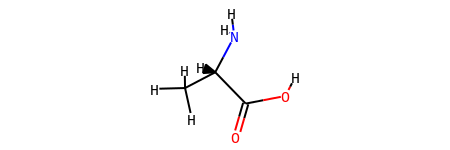

In [7]:
ala = Chem.MolFromSmiles( 'N[C@@H](C)C(O)=O' )
alaH = Chem.AddHs(ala)
rdDistGeom.EmbedMolecule(alaH)
alaH

Before= 22.00290186530056
After= 14.387139718103793


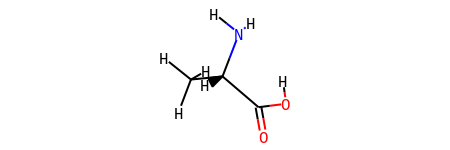

In [8]:
ff = AllChem.UFFGetMoleculeForceField(alaH)
print( "Before=", ff.CalcEnergy() )
AllChem.UFFOptimizeMolecule(alaH)
print( "After=", ff.CalcEnergy() )
alaH

Descriptors, Fingerprints

In [9]:
from rdkit.Chem import Descriptors
from rdkit.Chem.Fingerprints import FingerprintMols

165.192 0.6409999999999993 1 63.32


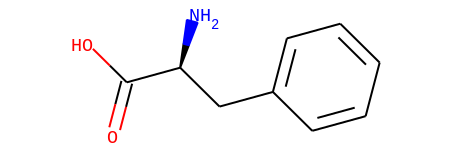

In [10]:
phe = Chem.MolFromSmiles('N[C@H](C(O)=O)Cc1ccccc1')
print( Descriptors.MolWt(phe), Descriptors.MolLogP(phe), Descriptors.RingCount(phe), Descriptors.TPSA(phe) )
phe

Database

306-molecules read...


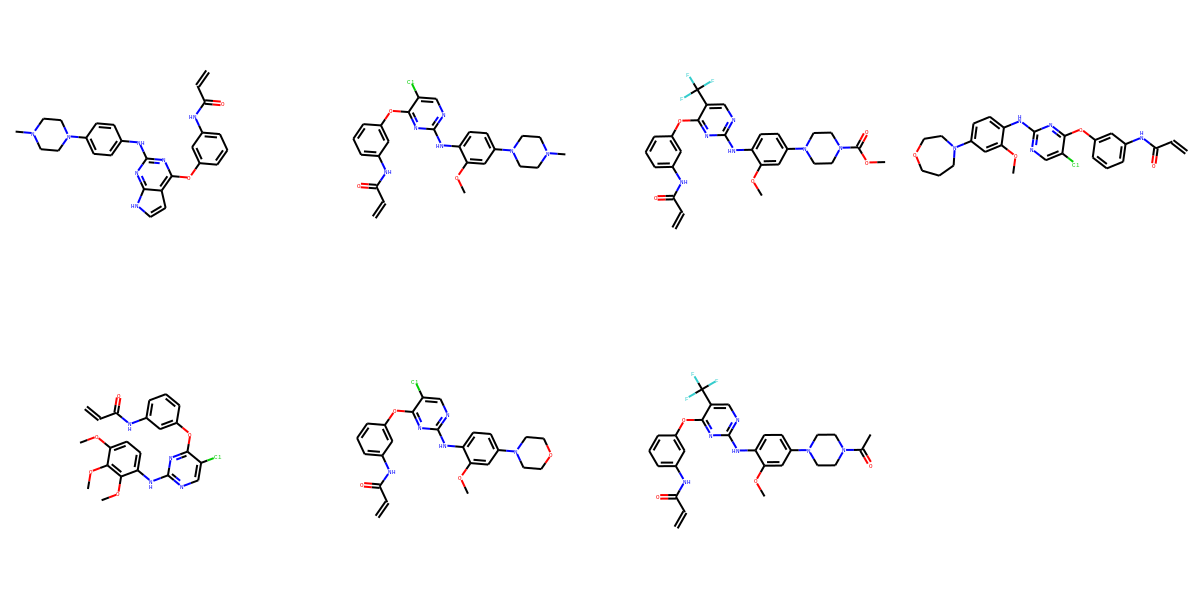

In [11]:
def mol_from_smiles( row ) :
    smiles = row[ 'smiles' ]
    m = Chem.MolFromSmiles( smiles )
    activity = row[ 'pChembl_Value' ]
    m.SetProp( 'pChembl_Value', str(activity) )
    return m


url_smi = 'https://raw.githubusercontent.com/chchae/VSLecture/master/data/egfr/ChEMBL27_EGFR_aminopyridine.smi'
db_smi = pd.read_table( url_smi, delimiter=' ', names=['smiles', 'pChembl_Value'], header=None, )
mols_egfr = [ mol_from_smiles(row) for _, row in db_smi.iterrows() ]

print( '%d-molecules read...' % len(mols_egfr) )
Draw.MolsToGridImage( mols_egfr[:7], molsPerRow=4, subImgSize=(300,300) )

Substructure search

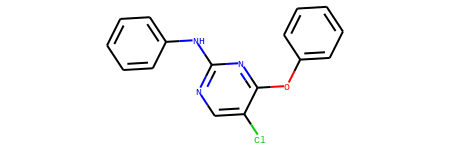

In [12]:
smiles = 'c1cc(ccc1Nc1ncc(Cl)c(Oc2ccccc2)n1)'
query = Chem.MolFromSmiles( smiles )
AllChem.Compute2DCoords(query)
query

Found =  81  from  306


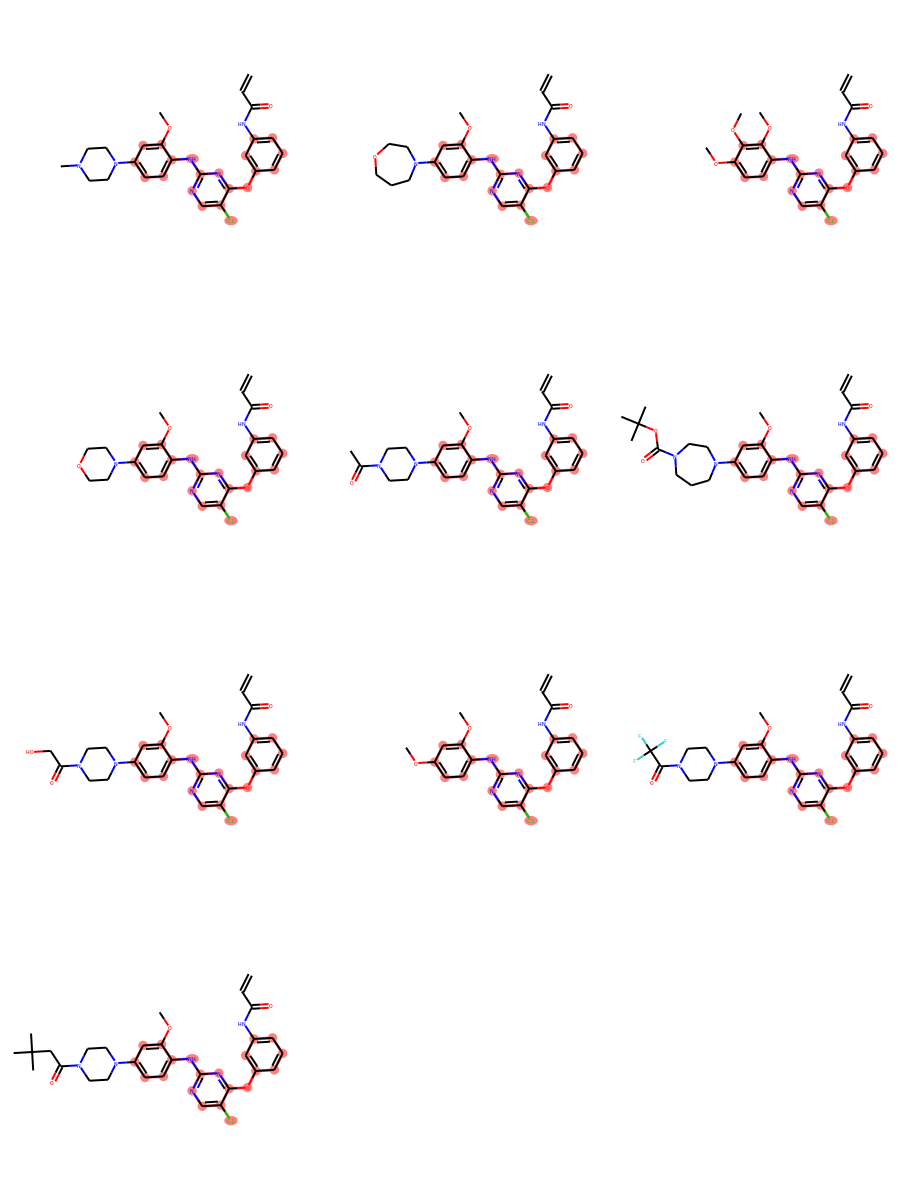

In [13]:
result = [ x for x in mols_egfr if x.HasSubstructMatch(query) ]
print( "Found = ", len( result ), " from ", len( mols_egfr ) )
for m in result:
    AllChem.GenerateDepictionMatching2DStructure( m, query )

Draw.MolsToGridImage( result[:10], molsPerRow=3, subImgSize=(300,300), highlightAtomLists=[ m.GetSubstructMatch(query) for m in result ]  )

MCS

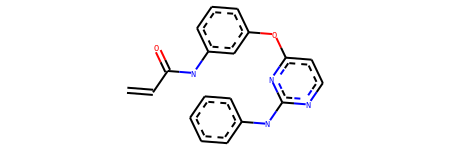

In [14]:
from rdkit.Chem import rdFMCS

mols_sub = mols_egfr[:20]
mcsf = rdFMCS.FindMCS( mols_sub )
mcs = Chem.MolFromSmarts( mcsf.smartsString )
mcs

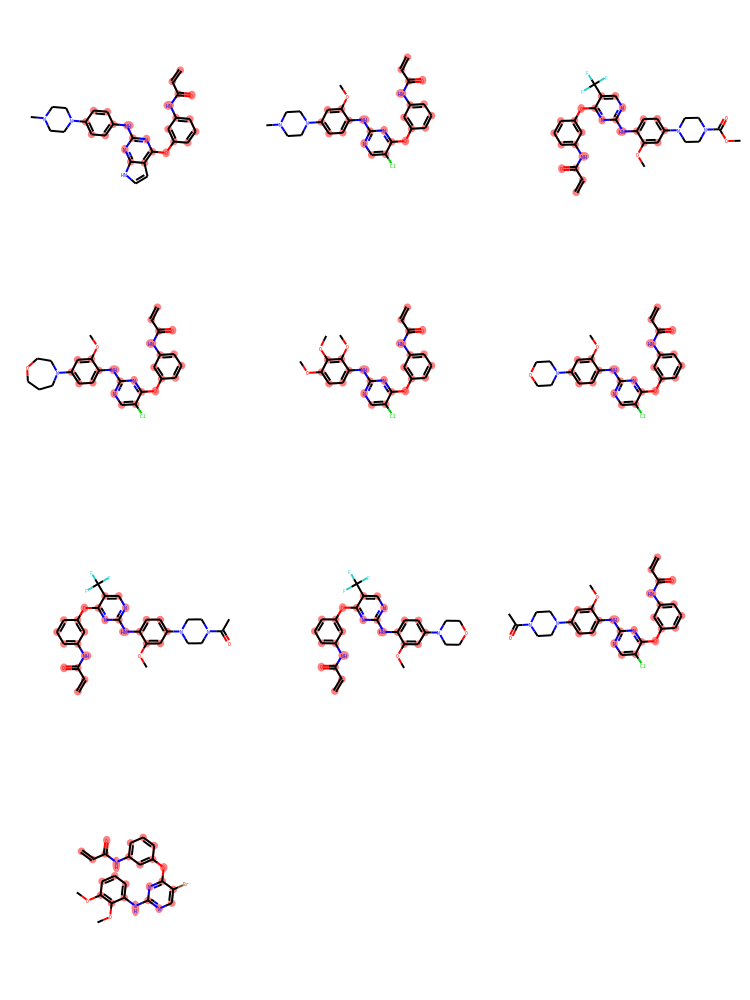

In [15]:
Draw.MolsToGridImage( mols_sub[:10], molsPerRow=3, subImgSize=(250,250), highlightAtomLists=[ m.GetSubstructMatch(mcs) for m in mols_sub ] )

R-Group decomposition

81 225
[{'Core': 'Clc1cnc(Nc2ccc([*:6])c([*:5])c2[*:4])nc1Oc1ccc([*:3])c([*:2])c1[*:1]', 'R1': '[H][*:1]', 'R2': 'C=CC(=O)N[*:2]', 'R3': '[H][*:3]', 'R4': 'CO[*:4]', 'R5': '[H][*:5]', 'R6': 'CN1CCN([*:6])CC1'}, {'Core': 'Clc1cnc(Nc2ccc([*:6])c([*:5])c2[*:4])nc1Oc1ccc([*:3])c([*:2])c1[*:1]', 'R1': '[H][*:1]', 'R2': 'C=CC(=O)N[*:2]', 'R3': '[H][*:3]', 'R4': 'CO[*:4]', 'R5': '[H][*:5]', 'R6': 'C1COCCN([*:6])C1'}, {'Core': 'Clc1cnc(Nc2ccc([*:6])c([*:5])c2[*:4])nc1Oc1ccc([*:3])c([*:2])c1[*:1]', 'R1': '[H][*:1]', 'R2': 'C=CC(=O)N[*:2]', 'R3': '[H][*:3]', 'R4': 'CO[*:4]', 'R5': 'CO[*:5]', 'R6': 'CO[*:6]'}]


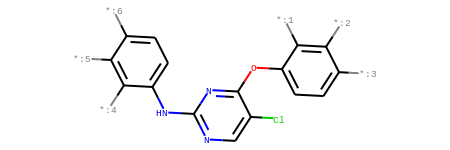

In [16]:
from rdkit.Chem import rdRGroupDecomposition as rdRGD

mcsf = rdFMCS.FindMCS( mols_egfr )
mcs = Chem.MolFromSmarts( mcsf.smartsString )
mcs = query

matched,unmatched = rdRGD.RGroupDecompose([mcs],mols_egfr[:],asSmiles=True)
print( len(matched), len(unmatched) )
print( matched[:3] )
Chem.MolFromSmiles( matched[4]['Core'])

Fingerprints

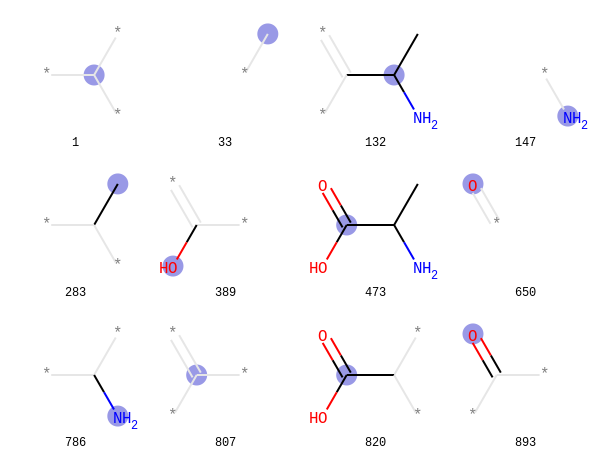

In [17]:
from rdkit.Chem.Fingerprints import FingerprintMols

ala = Chem.MolFromSmiles( 'CC(C(=O)O)N' )
bi = {}
fp = AllChem.GetMorganFingerprintAsBitVect( ala, 2, nBits=1024, bitInfo=bi )
#fp_arr = np.zeros( (1, ) )
#DataStructs.ConvertToNumpyArray( fp, fp_arr )
#np.nonzero( fp_arr )
#list( fp.GetOnBits() )

mfps = [ ( ala, x, bi ) for x in fp.GetOnBits() ]
Draw.DrawMorganBits( mfps, molsPerRow=4, subImgSize=(150,150), legends=[ str(x) for x in fp.GetOnBits() ] )

Fingerprint similarity search

In [18]:
fps = [ FingerprintMols.FingerprintMol(m) for m in mols_egfr ]
fp_ref = fps[1]

val = []
for i in range(len(fps)):
    val.append( DataStructs.FingerprintSimilarity( fp_ref, fps[i] ) )
print( np.array_str( np.array(val), precision=2 ) )

[0.65 1.   0.75 0.88 0.8  0.93 0.77 0.73 0.96 0.71 0.84 0.95 0.72 0.85
 0.92 0.69 0.68 0.91 0.72 0.61 0.67 0.73 0.88 0.88 0.76 0.89 0.87 0.76
 0.63 0.77 0.61 0.75 0.64 0.63 0.66 0.63 0.64 0.71 0.71 0.68 0.62 0.79
 0.73 0.85 0.63 0.63 0.7  0.6  0.77 0.63 0.76 0.63 0.9  0.83 0.57 0.76
 0.81 0.81 0.63 0.6  0.75 0.76 0.92 0.94 0.74 0.84 0.88 0.87 0.73 0.92
 0.93 0.86 0.9  0.85 0.61 0.89 0.95 0.96 0.89 0.83 0.8  0.61 0.92 0.95
 0.61 0.93 0.95 0.58 0.91 0.98 0.97 0.87 0.9  0.83 0.92 0.95 0.87 0.85
 0.91 0.85 0.88 0.87 0.91 0.92 0.81 0.85 0.88 0.87 0.88 0.91 0.5  0.49
 0.49 0.52 0.5  0.47 0.48 0.44 0.53 0.49 0.5  0.51 0.46 0.49 0.5  0.5
 0.49 0.51 0.51 0.47 0.52 0.52 0.49 0.51 0.49 0.51 0.5  0.5  0.43 0.51
 0.44 0.51 0.51 0.5  0.51 0.49 0.5  0.5  0.43 0.56 0.51 0.48 0.52 0.51
 0.44 0.5  0.53 0.52 0.52 0.53 0.52 0.51 0.48 0.51 0.51 0.51 0.51 0.51
 0.48 0.53 0.46 0.53 0.51 0.49 0.5  0.48 0.5  0.47 0.54 0.48 0.55 0.56
 0.6  0.55 0.51 0.58 0.53 0.56 0.57 0.53 0.55 0.48 0.5  0.51 0.49 0.42
 0.46 0

Fingerprint similarity density map

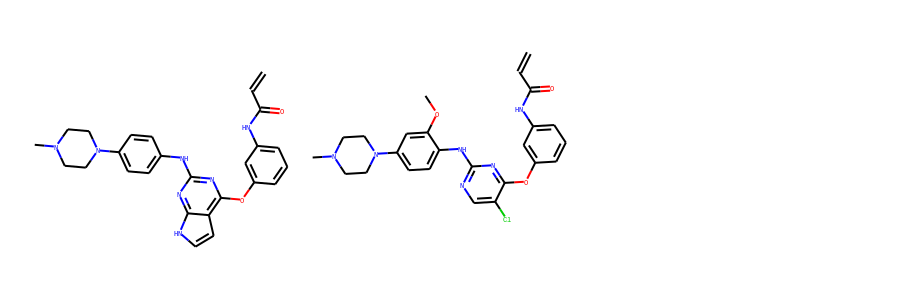

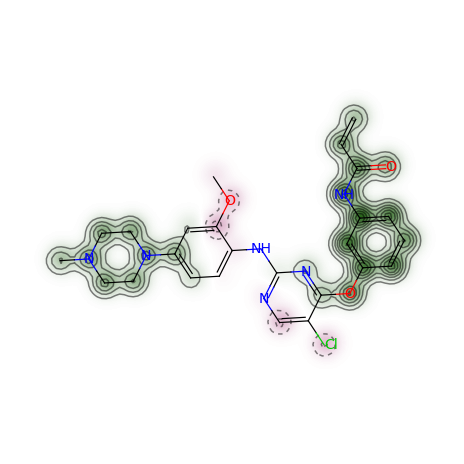

In [19]:
from rdkit.Chem.Draw import SimilarityMaps

ref = mols_sub[0]
mol = mols_sub[1]
fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint( ref, mol, SimilarityMaps.GetMorganFingerprint )

Draw.MolsToGridImage( [ref, mol], molsPerRow=3, subImgSize=(300,300) )

Fingerprint descriptors map - charge and logP

Charges =  [-0.09358991854301577, -0.003956975576191903, 0.24726456668062793, -0.2696480622101046, -0.3223931149276884, 0.04467408980828689, -0.038251682852486216, -0.05649333244031857, -0.01907771727455852, 0.13110971938310126, 0.004446080210662932, -0.4380416880747996, 0.23311161342544373, 0.08147895710961545, 0.1463553925152271, -0.029609010346172172, 0.0033924515283658254, -0.3458645436988424, -0.17606141665813105, 0.23205251307006627, -0.19443948118529558, -0.32402056589798, 0.04102571212272887, -0.036468671449766385, -0.0366908199292375, 0.03681005589562408, -0.0366908199292375, -0.036468671449766385, -0.3689647154567249, 0.030576547955533273, 0.01554920108912078, -0.3028559431986506, -0.013239811541794776, 0.01554920108912078, 0.030576547955533273]


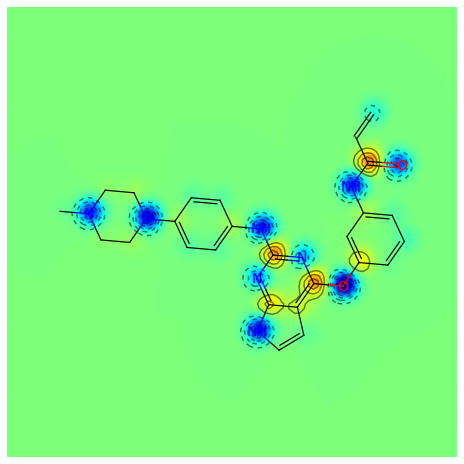

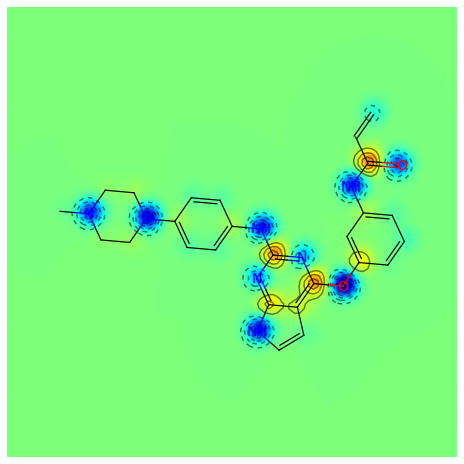

In [20]:
from rdkit.Chem import rdMolDescriptors

m = mols_sub[0]
#m = Chem.MolFromSmiles( 'Cc1c(Nc2nccc(c3cccnc3)n2)cc(NC(c4ccc(CN5CCN(C)CC5)cc4)=O)cc1' )

AllChem.ComputeGasteigerCharges( m )

charges = [ m.GetAtomWithIdx(i).GetDoubleProp('_GasteigerCharge') for i in range(m.GetNumAtoms()) ]
print( "Charges = ", charges )
SimilarityMaps.GetSimilarityMapFromWeights(m, charges, colorMap='jet', contourLines=10)

(LogP, MR) =  [(0.1551, 3.513), (0.1551, 3.513), (-0.2783, 5.007), (-0.1526, 0.0), (-0.5188, 3.0), (0.4619, 4.067), (0.1581, 3.35), (0.1581, 3.35), (0.1581, 3.35), (0.5437, 3.853), (0.1581, 3.35), (-0.4195, 1.182), (0.5437, 3.853), (0.2955, 4.346), (0.2955, 4.346), (0.1581, 3.35), (0.1581, 3.35), (-0.3239, 2.202), (-0.3239, 2.202), (0.4619, 4.067), (-0.3239, 2.202), (-0.5188, 3.0), (0.4619, 4.067), (0.1581, 3.35), (0.1581, 3.35), (0.4619, 4.067), (0.1581, 3.35), (0.1581, 3.35), (-0.4458, 2.819), (-0.2035, 2.753), (-0.2035, 2.753), (-0.3187, 1.839), (-0.2035, 2.753), (-0.2035, 2.753), (-0.2035, 2.753)]


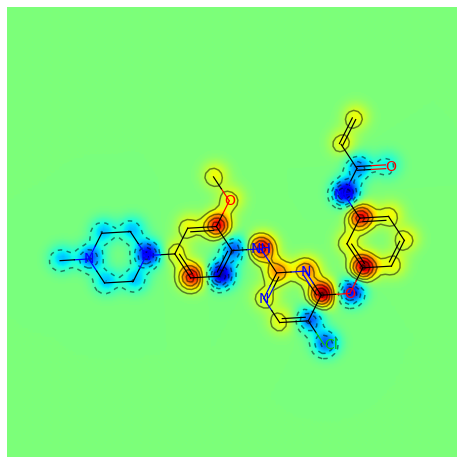

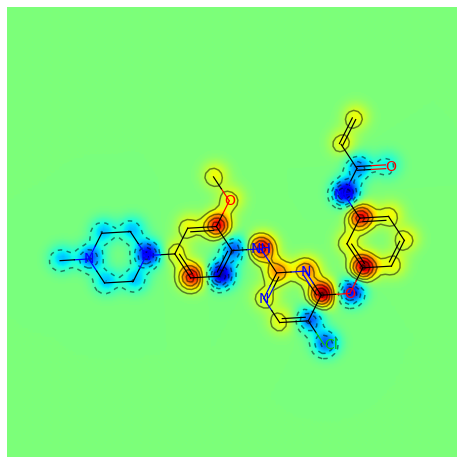

In [21]:
logpmr = rdMolDescriptors._CalcCrippenContribs(m)
print( "(LogP, MR) = ", logpmr )
SimilarityMaps.GetSimilarityMapFromWeights(mol,[x for x,y in logpmr], colorMap='jet', contourLines=10)

SMIRKS - Chemical Reactions

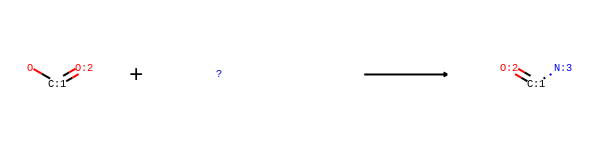

In [22]:
rxn = AllChem.ReactionFromSmarts('[C:1](=[O:2])-[OD1].[N!H0:3]>>[C:1](=[O:2])[N:3]')
rxn

2


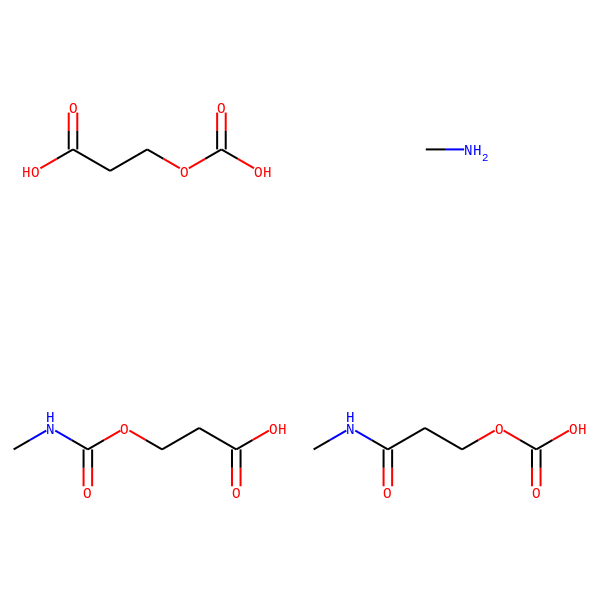

In [23]:
rx1 = Chem.MolFromSmiles('C(COC(=O)O)C(=O)O')
rx2 = Chem.MolFromSmiles('NC')
ps = rxn.RunReactants((rx1,rx2) )
print( len(ps) )
Draw.MolsToGridImage( [ rx1, rx2, ps[0][0], ps[1][0] ], molsPerRow=2, subImgSize=(300,300) )

RECAP

dict_keys(['*C(=O)CC', '*OCCOc1ccccc1', '*c1ccccc1', '*CCOC(=O)CC', '*CCOc1ccccc1'])


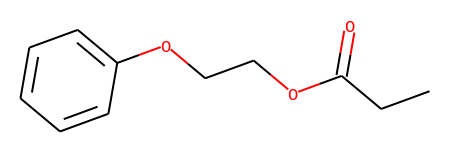

In [24]:
from rdkit.Chem import Recap
m = Chem.MolFromSmiles('c1ccccc1OCCOC(=O)CC')
# m = Chem.MolFromSmiles( 'Cc1c(Nc2nccc(c3cccnc3)n2)cc(NC(c4ccc(CN5CCN(C)CC5)cc4)=O)cc1' )
hierarch = Recap.RecapDecompose(m)
print( hierarch.children.keys() )
hierarch.mol